# Задание

Произведем А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

### Описание колонок:
* experimentVariant – вариант эксперимента
* version – версия приложения
* purchase – факт покупки
 

### Задача
1. Запустить A/A-тест
2. Посчитайть FPR на уровне альфа = 0.05 (используются подвыборки без возвращения объемом 1000). Если FPR > альфа сплит система работает некорректно.
3. Найти причины поломки сплит-системы, ориентируясь на результаты эксперимента
4. Написать выводы, которые можно сделать на основе анализа результатов A/A-теста


In [85]:
# импорт нужных библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import ttest_ind

In [8]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';', index_col=0)

In [9]:
data.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [11]:
# проверка все ли в порядке с данными
data.isna().sum() 

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [33]:
data.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [27]:
# разделим данные по группам
data_0 = data.query('experimentVariant == 0')
data_1 = data.query('experimentVariant == 1')

In [28]:
data_0.head()

,uid,experimentVariant,version,purchase
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
7,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
9,45c48cce2e2d7fbdea1afc51c7c6ad26,0,v2.8.0,0
12,c20ad4d76fe97759aa27a0c99bff6710,0,v2.8.0,0
17,70efdf2ec9b086079795c442636b55fb,0,v2.8.0,0


In [29]:
data_1.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
6,1679091c5a880faf6fb5e6087eb1b2dc,1,v2.8.0,0


Проведем А/А-тестирование, чтобы убедиться что сплит-система сломана

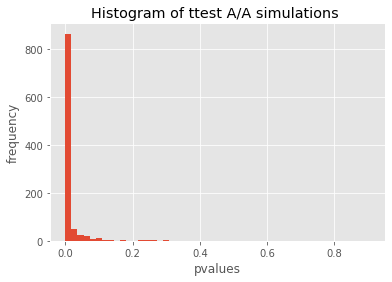

In [38]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data_0.purchase.sample(n_s, replace = False).values
    s2 = data_1.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [37]:
# проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.927

### По полученным результатам, можно убедиться, что сплит-система действительно сломана. 

Рассмотрим возможную причину поломки - сильное отличие конверсии внутри группировок

In [23]:
# группировка по варианту и версии МП
data_gr = data.groupby(['experimentVariant','version'], as_index = False) \
    .agg({'purchase':'sum','uid':'count'})

data_gr

,experimentVariant,version,purchase,uid
0,0,v2.8.0,41,41283
1,0,v2.9.0,890,11921
2,0,v3.7.4.0,252,4204
3,0,v3.8.0.0,328,5694
4,1,v2.8.0,1895,41552
5,1,v2.9.0,858,12033
6,1,v3.7.4.0,266,4221
7,1,v3.8.0.0,384,6110


In [24]:
# расчет conversion rate
data_gr['conv_rate'] = data_gr.purchase/ data_gr.uid 

In [25]:
data_gr

,experimentVariant,version,purchase,uid,conv_rate
0,0,v2.8.0,41,41283,0.000993
1,0,v2.9.0,890,11921,0.074658
2,0,v3.7.4.0,252,4204,0.059943
3,0,v3.8.0.0,328,5694,0.057604
4,1,v2.8.0,1895,41552,0.045606
5,1,v2.9.0,858,12033,0.071304
6,1,v3.7.4.0,266,4221,0.063018
7,1,v3.8.0.0,384,6110,0.062848


### Уже можно заметить, что для v2.8.0 conversion rate для двух экспериментов сильно отличается. 

Проверим в этом ли дело поломки, и есть ли еще менее видимые причины - посчитаем pvalue для каждой версии МП с помощью T-теста

In [88]:
ttest_ind(data[(data.version == 'v2.8.0') & (data.experimentVariant == 0)].purchase ,
         data[(data.version == 'v2.8.0') & (data.experimentVariant == 1)].purchase)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [89]:
ttest_ind(data[(data.version == 'v2.9.0') & (data.experimentVariant == 0)].purchase ,
         data[(data.version == 'v2.9.0') & (data.experimentVariant == 1)].purchase)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [90]:
ttest_ind(data[(data.version == 'v3.7.4.0') & (data.experimentVariant == 0)].purchase ,
         data[(data.version == 'v3.7.4.0') & (data.experimentVariant == 1)].purchase)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [91]:
ttest_ind(data[(data.version == 'v3.8.0.0') & (data.experimentVariant == 0)].purchase ,
         data[(data.version == 'v3.8.0.0') & (data.experimentVariant == 1)].purchase)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Исключим версию с pvalue < 0.05 из основного датафрейма

In [92]:
data_new = data.query('version != "v2.8.0"')

In [93]:
data_new_0 = data_new.query('experimentVariant == 0')
data_new_1 = data_new.query('experimentVariant == 1')

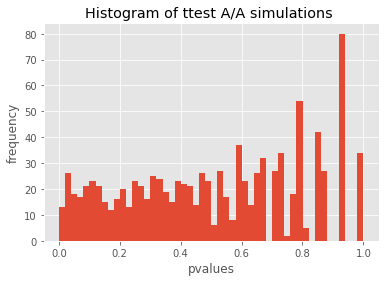

In [94]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data_new_0.purchase.sample(n_s, replace = False).values
    s2 = data_new_1.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [98]:
sum(np.array(res) <0.05) / simulations # проверка FPR < альфа

0.043

## Заключение:

* Была выполнена проверка сплит-системы с помощью A/A-теста и подтвердилось, что сплит-система работает некорректно
* Была произведена проверка на сильное отличие конверсии внутри группировок. Сильное отличие конверсии подвердилось для v2.8.0
* При проверке сплит-системы с помощью A/A теста без учета версии v2.8.0, выполняется условие FPR < альфа. Однако полученное частотное распределение pvals, может свидетельствовать о других проблемах. 